# EMO task

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [9]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [4]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-12 09:14:33--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27697 (27K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  27.05K  --.-KB/s    in 0.002s  

2023-07-12 09:14:34 (14.8 MB/s) - ‘utils.py’ saved [27697/27697]

--2023-07-12 09:14:34--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [5]:
EMO_json_path_train = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_train.json"
EMP_json_path_train = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_train.json"
EMO_json_path_dev = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_dev.json"
EMP_json_path_dev = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_dev.json"
EMO_json_path_test = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_test.json"
EMP_json_path_test = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_test.json"

!wget {EMO_json_path_train}
!wget {EMP_json_path_train}
!wget {EMO_json_path_dev}
!wget {EMP_json_path_dev}
!wget {EMO_json_path_test}
!wget {EMP_json_path_test}

--2023-07-12 09:14:34--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/EMO23_lexicon_per_word_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13477977 (13M) [text/plain]
Saving to: ‘EMO23_lexicon_per_word_train.json’

EMO23_lexicon_per_w 100%[===================>]  12.85M  75.7MB/s    in 0.2s    

2023-07-12 09:14:34 (75.7 MB/s) - ‘EMO23_lexicon_per_word_train.json’ saved [13477977/13477977]

--2023-07-12 09:14:34--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/EMP23_lexicon_per_word_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

In [1]:
import json
import torch
import string
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch
from torch import nn
from transformers import AutoConfig, BertForSequenceClassification, RobertaForSequenceClassification, RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from nrclex import NRCLex
import importlib
import sys
from torch.utils.data import Dataset
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [10]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Dataset

### WASSA dataset

In [11]:
emotions_names = [
    'fear',
    'anger',
    'anticipation',
    'trust',
    'surprise',
    'positive',
    'negative',
    'sadness',
    'disgust',
    'joy',
    'hope'
]

In [12]:
class WASSADataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        essay_id,
        targets,
        sep=False,
        prompt=None,
        EMP_lexicon = None,
        EMO_lexicon = None,
        global_features = None,
        local_emotions = False,
        local_empathy = False,
        local_distress = False,
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.essay_id = essay_id
        self.targets = targets
        self.EMP_lexicon = EMP_lexicon
        self.EMO_lexicon = EMO_lexicon
        self.sep = sep
        self.prompt = prompt

        self.global_features = global_features
        self.local_emotions = local_emotions
        self.local_empathy = local_empathy
        self.local_distress = local_distress

    def __len__(self):
        print("dentro len")
        return len(self.essay) # len(self.essay) + 1 + len(self.prompt) if self.prompt is not None else len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])

        essay_id = self.essay_id[index]


        if self.prompt is not None:
          prompt = str(self.prompt[index])

        text = essay
        text_pair = None
        if self.sep:
          text_pair = prompt
        else:
          if self.prompt is not None:
            text += " " + prompt

        inputs = self.tokenizer.encode_plus(
            text=essay,
            text_pair=text_pair,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }

        if self.targets is not None:
          item['labels'] = torch.FloatTensor(self.targets[index])

        if self.global_features is not None:
          item['global_features'] = self.global_features[index]

        n_local_features = 0
        features_tokens_row = []
        if self.local_emotions:
            n_local_features += len(emotions_names)
            for i in range(len(emotions_names)):
                features_tokens_row.append(0)
        if self.local_empathy:
            n_local_features += 1
            features_tokens_row.append(4)
        if self.local_distress:
            n_local_features += 1
            features_tokens_row.append(0)

        if n_local_features > 0:
            features_tokens = np.full((self.tokenizer.model_max_length, n_local_features), features_tokens_row)
        else:
          features_tokens = None

        word_count=0
        first_char=True
        last_char_is_space=False
        for char_idx, char in enumerate(essay):
          token_idx = inputs.char_to_token(char_idx)
          if token_idx is None:
            if first_char: last_char_is_space=True
            if not last_char_is_space and not first_char:
              word_count+=1
              last_char_is_space=True
            continue
          elif last_char_is_space:
            last_char_is_space=False
          first_char=False

          j = 0
          if char not in string.punctuation:
            if self.local_emotions:
              for i, emo in enumerate(emotions_names):
                features_tokens[token_idx][i] = self.EMO_lexicon[str(essay_id)][emo][word_count]
              j += len(emotions_names)

            if self.local_empathy:
              features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['empathy'][word_count]
              j += 1


            if self.local_distress:
              features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['distress'][word_count]

        if features_tokens is not None:
            item['local_features'] = torch.FloatTensor(features_tokens)

        #item['return_dict']=True

        return item

Dataset paths

In [13]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_original_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_original_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [14]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

In [15]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

Optional subsample

In [13]:
"""train_df = train_df[:10]
val_df = val_df[:10]
dev_df = dev_df[:10]"""

'train_df = train_df[:10]\nval_df = val_df[:10]\ndev_df = dev_df[:10]'

Encode targets

In [14]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

In [15]:
#@title Global Features
emo_count_global = True #@param {type:"boolean"}
empathy_count_global = True #@param {type:"boolean"}
distress_count_global = True #@param {type:"boolean"}
bio_global = True #@param {type:"boolean"}
global_features_names = []
emotions_count = ['fear_count',	'anger_count','anticipation_count',	'trust_count',
                 'positive_count',	'negative_count', 'surprise_count',
                 'sadness_count',	'disgust_count',	'joy_count',	'hope_count']
bio = ['gender', 'age', 'income', 'race', 'education']
if emo_count_global:
  for emo in emotions_count: global_features_names.append(emo)
if empathy_count_global: global_features_names.append('empathy')
if distress_count_global: global_features_names.append('distress')
if bio_global:
  for b in bio: global_features_names.append(b)


In [16]:
#@title Local Features
emo_count_local = True #@param {type:"boolean"}
empathy_count_local = True #@param {type:"boolean"}
distress_count_local = True #@param {type:"boolean"}

local_features_names = []
if emo_count_local: local_features_names.append('emotions')
if empathy_count_local: local_features_names.append('empathy')
if distress_count_local: local_features_names.append('distress')



In [17]:
#@title Number of labels
num_labels = 8 #@param {type:"number"}


In [18]:
NUM_LABELS = num_labels
GLOBAL_FEATURES_NAMES = global_features_names
LOCAL_FEATURES_NAMES = local_features_names
DIM_EXTRA_FEATURES_GLOBAL = len(GLOBAL_FEATURES_NAMES)

Extra global features

In [19]:
features_train =  np.array(train_df[GLOBAL_FEATURES_NAMES])
features_val =  np.array(val_df[GLOBAL_FEATURES_NAMES])
features_dev =  np.array(dev_df[GLOBAL_FEATURES_NAMES])

## Lexicons

In [20]:
with open("/content/EMO23_lexicon_per_word_train.json") as json_file:
  EMO_lexicon_train_dict = json.load(json_file)
with open("/content/EMP23_lexicon_per_word_train.json") as json_file:
  EMP_lexicon_train_dict = json.load(json_file)
with open("/content/EMO23_lexicon_per_word_dev.json") as json_file:
  EMO_lexicon_dev_dict = json.load(json_file)
with open("/content/EMP23_lexicon_per_word_dev.json") as json_file:
  EMP_lexicon_dev_dict = json.load(json_file)
with open("/content/EMO23_lexicon_per_word_test.json") as json_file:
  EMO_lexicon_test_dict = json.load(json_file)
with open("/content/EMP23_lexicon_per_word_test.json") as json_file:
  EMP_lexicon_test_dict = json.load(json_file)

## Model

In [33]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base': 'bert-base-cased',
  'roberta-base' : 'bert-base'
}

In [34]:
model_config = {
    'model_id': 'roberta_lexicon',
    'tokenizer_name': model_type.get('bert-base'),
    'model_name': model_type.get('bert-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0,
    'weighted_loss': True
}

In [35]:
def get_loss_weights(y):
  inverse_n_samples = 1 / np.sum(y, axis=0)
  sum_inverses = sum(inverse_n_samples)
  weights_train = inverse_n_samples / sum_inverses
  return torch.cuda.FloatTensor(weights_train)

In [36]:
if model_config.get('weighted_loss'):
  loss_weights_train = get_loss_weights(y_train)


In [37]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

### Custom "lexicon" model

In [3]:
class ClassificationHead(nn.Module):
    #Head for sentence-level classification tasks.

    def __init__(self, config, num_extra_dims, hidden_layers_to_concat, classifier_dropout, local_features):
        super().__init__()
        self.local_features = local_features
        total_dims = config.hidden_size*hidden_layers_to_concat + num_extra_dims
        if self.local_features:
          total_dims += config.hidden_size
        self.dense = nn.Linear(total_dims, total_dims)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(BertForSequenceClassification):

    def __init__(self, config, num_extra_dims=0, local_features_name=None, loss_weights=None, last_cls = 1, mean_last_cls = False):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.local_features_name = local_features_name
        self.loss_weights = loss_weights
        self.last_cls = last_cls
        self.mean_last_cls = mean_last_cls
        self.bert =  BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = ClassificationHead(config, num_extra_dims, last_cls, classifier_dropout, local_features_name is not None)
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        local_features = None,
        global_features = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r'''
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        '''
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        cls_tokens = []
        for i in range(1, self.last_cls + 1):
            cls_tokens.append(outputs.hidden_states[-1 * i][:, 0, :])
        if self.mean_last_cls:
          # average cls tokens
          output = torch.mean(torch.stack(cls_tokens), dim=0)
        else:
          # concat cls tokens
          output = torch.cat(cls_tokens, dim=1)

        output = self.dropout(output)

        if local_features is not None:
          tokens_output = outputs.last_hidden_state
          tokens_output = self.dropout(tokens_output)

          tokens_output = torch.cat((
                  tokens_output,
                  local_features.reshape(outputs.last_hidden_state.shape[0], outputs.last_hidden_state.shape[1], -1)),
                             dim=2)

          mask = torch.zeros_like(attention_mask)
          # unmask tokens with high or low empathy, high distress levels, or expressing at least one emotion
          j = 0
          if 'emotions' in self.local_features_name:
            emotion_values = local_features[:,:,:11]
            mask[emotion_values.sum(dim=-1)>=1] = 1.0
            j += 11

          if 'empathy' in self.local_features_name:
            empathy_values = local_features[:,:,j]
            mask[(empathy_values>5) | ((empathy_values<3) & (empathy_values>=1))] = 1.0
            j += 1

          if 'distress' in self.local_features_name:
            distress_values = local_features[:,:,j]
            mask[distress_values>4] = 1.0

          # mean pooling of unmasked tokens
          input_mask_expanded = mask.unsqueeze(-1).expand(tokens_output.size()).float()
          sum_embeddings = torch.sum(tokens_output * input_mask_expanded, 1)
          sum_mask = input_mask_expanded.sum(1)
          sum_mask = torch.clamp(sum_mask, min = 1e-9)
          tokens_output = sum_embeddings/sum_mask

          # concat pooled tokens lexically relevant with cls token
          output = torch.cat((output, tokens_output), dim=-1)


        if global_features is not None: # global
          output = torch.cat((output, global_features), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss(weight = self.loss_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss(weight = self.loss_weights)
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
"""class ClassificationHead(nn.Module):
    #Head for sentence-level classification tasks.

    def __init__(self, config, num_extra_dims, hidden_layers_to_concat, classifier_dropout, local_features):
        super().__init__()
        self.local_features = local_features
        total_dims = config.hidden_size*hidden_layers_to_concat + num_extra_dims
        if self.local_features:
          total_dims += config.hidden_size
        self.dense = nn.Linear(total_dims, total_dims)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims=0, local_features_name=None, loss_weights=None, last_cls = 1, mean_last_cls = False):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.local_features_name = local_features_name
        self.loss_weights = loss_weights
        self.last_cls = last_cls
        self.mean_last_cls = mean_last_cls
        self.bert =  RobertaModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = ClassificationHead(config, num_extra_dims, last_cls, classifier_dropout, local_features_name is not None)
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        local_features = None,
        global_features = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = True, # None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r'''
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        '''
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        cls_tokens = []
        for i in range(1, self.last_cls + 1):
            cls_tokens.append(outputs.hidden_states[-1 * i][:, 0, :])
        if self.mean_last_cls:
          # average cls tokens
          output = torch.mean(torch.stack(cls_tokens), dim=0)
        else:
          # concat cls tokens
          output = torch.cat(cls_tokens, dim=1)

        output = self.dropout(output)

        if local_features is not None:
          tokens_output = outputs.last_hidden_state
          tokens_output = self.dropout(tokens_output)

          tokens_output = torch.cat((
                  tokens_output,
                  local_features.reshape(outputs.last_hidden_state.shape[0], outputs.last_hidden_state.shape[1], -1)),
                             dim=2)

          mask = torch.zeros_like(attention_mask)
          # unmask tokens with high or low empathy, high distress levels, or expressing at least one emotion
          j = 0
          if 'emotions' in self.local_features_name:
            emotion_values = local_features[:,:,:11]
            mask[emotion_values.sum(dim=-1)>=1] = 1.0
            j += 11

          if 'empathy' in self.local_features_name:
            empathy_values = local_features[:,:,j]
            mask[(empathy_values>5) | ((empathy_values<3) & (empathy_values>=1))] = 1.0
            j += 1

          if 'distress' in self.local_features_name:
            distress_values = local_features[:,:,j]
            mask[distress_values>4] = 1.0

          # mean pooling of unmasked tokens
          input_mask_expanded = mask.unsqueeze(-1).expand(tokens_output.size()).float()
          sum_embeddings = torch.sum(tokens_output * input_mask_expanded, 1)
          sum_mask = input_mask_expanded.sum(1)
          sum_mask = torch.clamp(sum_mask, min = 1e-9)
          tokens_output = sum_embeddings/sum_mask

          # concat pooled tokens lexically relevant with cls token
          output = torch.cat((output, tokens_output), dim=-1)


        if global_features is not None: # global
          output = torch.cat((output, global_features), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss(weight = self.loss_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss(weight = self.loss_weights)
                loss = loss_fct(logits, labels)

        if not return_dict: # TODO:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        seq = SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
        return seq"""

'class ClassificationHead(nn.Module):\n    #Head for sentence-level classification tasks.\n\n    def __init__(self, config, num_extra_dims, hidden_layers_to_concat, classifier_dropout, local_features):\n        super().__init__()\n        self.local_features = local_features\n        total_dims = config.hidden_size*hidden_layers_to_concat + num_extra_dims\n        if self.local_features:\n          total_dims += config.hidden_size\n        self.dense = nn.Linear(total_dims, total_dims)\n        self.dropout = nn.Dropout(classifier_dropout)\n        self.out_proj = nn.Linear(total_dims, config.num_labels)\n\n    def forward(self, features, **kwargs):\n        x = self.dense(features)\n        x = torch.tanh(x)\n        x = self.dropout(x)\n        x = self.out_proj(x)\n        return x\n\nclass CustomSequenceClassification(RobertaForSequenceClassification):\n\n    def __init__(self, config, num_extra_dims=0, local_features_name=None, loss_weights=None, last_cls = 1, mean_last_cls = Fals

In [39]:
model = CustomSequenceClassification.from_pretrained(model_config.get("model_name"),
                                                     problem_type = "multi_label_classification",
                                                     num_labels=NUM_LABELS,
                                                     classifier_dropout=0.3,
                                                     num_extra_dims = 0
                                                     #num_extra_dims = DIM_EXTRA_FEATURES_GLOBAL,
                                                     #local_features_name = LOCAL_FEATURES_NAMES,
                                                     #loss_weights = loss_weights_train
                                                     )

Some weights of the model checkpoint at bert-base-cased were not used when initializing CustomSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing CustomSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initializ

## Training

Prepare datasets

In [40]:
train_set = WASSADataset(tokenizer=tokenizer,
                       EMO_lexicon=EMO_lexicon_train_dict,
                       EMP_lexicon=EMP_lexicon_train_dict,
                       essay=train_df.essay,
                       essay_id = train_df.essay_id,
                       targets=y_train #,
                       #global_features = features_train,
                       #local_emotions = True,
                       #local_empathy = True,
                       #local_distress = True
                      )

val_set = WASSADataset(tokenizer=tokenizer,
                     EMO_lexicon=EMO_lexicon_train_dict,
                     EMP_lexicon=EMP_lexicon_train_dict,
                     essay=val_df.essay,
                     essay_id = val_df.essay_id,
                     targets=y_val #,
                     #global_features = features_val,
                     #local_emotions = True,
                     #local_empathy = True,
                     #local_distress = True
                    )
dev_set = WASSADataset(tokenizer=tokenizer,
                     EMO_lexicon=EMO_lexicon_train_dict,
                     EMP_lexicon=EMP_lexicon_train_dict,
                     essay=dev_df.essay,
                     essay_id = dev_df.essay_id,
                     targets=y_dev #,
                     #global_features = features_val,
                     #local_emotions = True,
                     #local_empathy = True,
                     #local_distress = True
                    )

Set up training

In [41]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 300,
    save_steps = 300,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss', # TODO: change
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [42]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

dentro len


Callbacks

In [43]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [44]:
trainer.train() # cambiare dropout, cambiare batch size, stampare predizioni, dentro len?

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
300,0.327400,0.266248,0.257323,0.650000,0.481481,0.260795,0.260381,0.717791,0.593909,0.564417,0.776177
600,0.190000,0.269823,0.295221,0.661111,0.493776,0.334466,0.289418,0.730061,0.604061,0.570552,0.782157
900,0.119300,0.288014,0.431596,0.677686,0.512500,0.642691,0.370645,0.740964,0.624365,0.576687,0.792761
1200,0.066200,0.272682,0.473617,0.711590,0.552301,0.623855,0.421490,0.758621,0.670051,0.588957,0.816055
1500,0.040200,0.289041,0.459437,0.700809,0.539419,0.607171,0.407161,0.747126,0.659898,0.576687,0.810076


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1540, training_loss=0.13222367391957865, metrics={'train_runtime': 742.2486, 'train_samples_per_second': 8.299, 'train_steps_per_second': 2.075, 'train_loss': 0.13222367391957865, 'epoch': 10.0})

In [45]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
train_epochs = [log.get('epoch') for log in train_logs if log.get('loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [46]:
import seaborn as sns

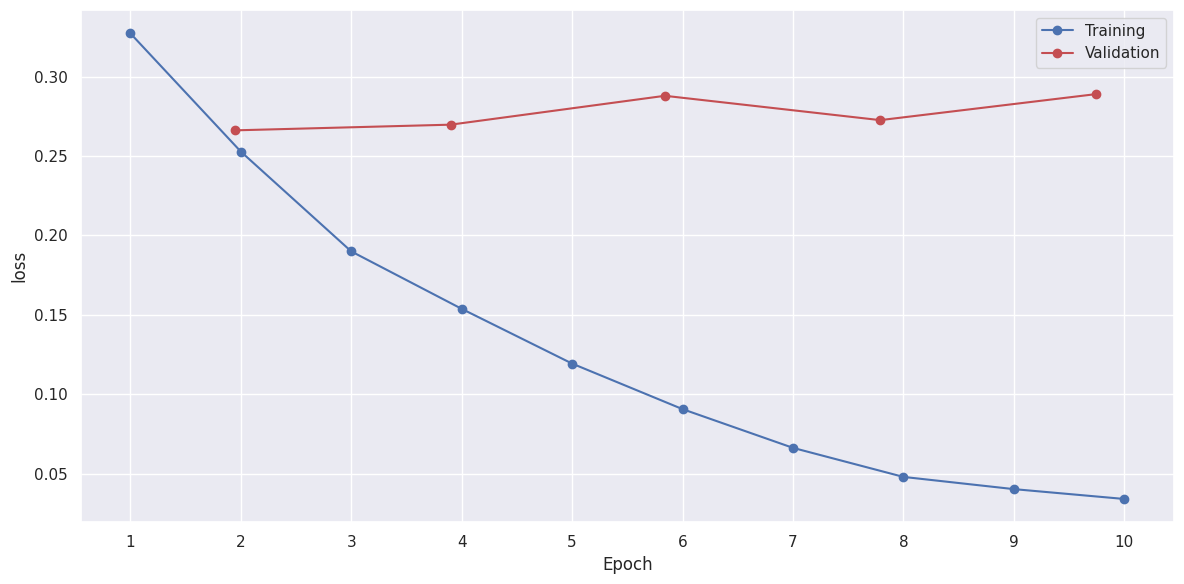

In [47]:
plot_metric_curve(train_loss_values, eval_loss_values, train_epochs, eval_epochs, "loss")

## Evaluation

In [48]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [51]:
outs = trainer.predict(dev_set)

dentro len
dentro len
dentro len
dentro len
dentro len


dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len
dentro len


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs.predictions[0], gold_emotions)

In [55]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.561,
 'micro_precision': 0.6635,
 'micro_f': 0.6079,
 'macro_recall': 0.2319,
 'macro_precision': 0.2702,
 'macro_F': 0.2307,
 'accuracy': 0.4367}

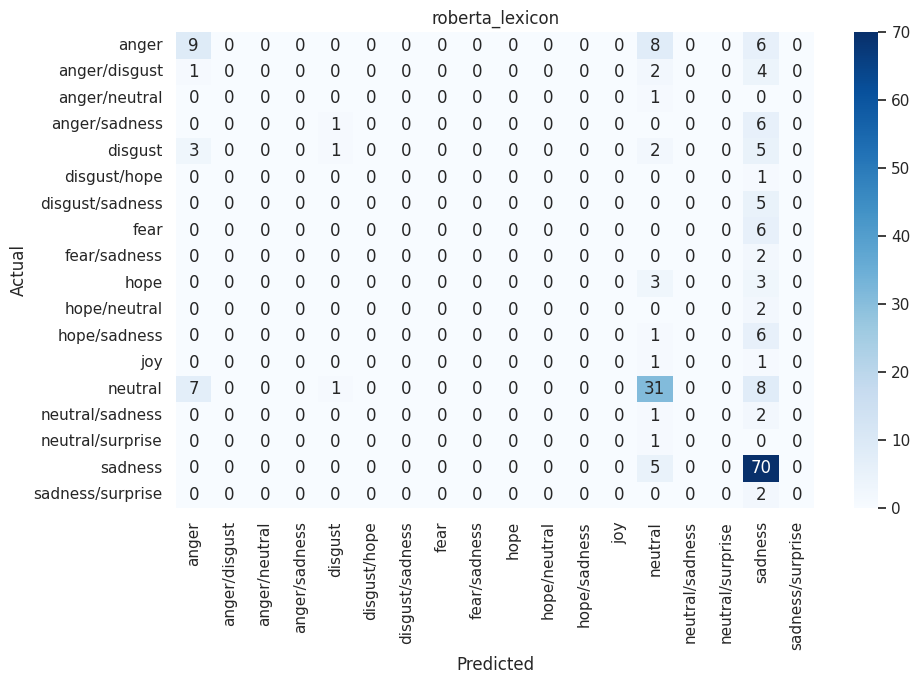

In [56]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [57]:
# Define the desired label names
label_names = ['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# Compute the confusion matrix
cm = confusion_matrix(gold_emotions, predicted_emotions, labels=label_names)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Add numbers in each cell
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:331 in                │
│ confusion_matrix                                                                                 │
│                                                                                                  │
│    328 │   │   elif y_true.size == 0:                                                            │
│    329 │   │   │   return np.zeros((n_labels, n_labels), dtype=int)                              │
│    330 │   │   elif len(np.intersect1d(y_true, labels)) == 0:                                    │
│ ❱  331 │   │   │   raise ValueError("At least one label specified must be in y_true")            │
│    332 │                                                                                         │
│    333 │   if sample_weight is None:                                                             │
│    334 │   │   sample_weight = np.ones(y_true.shape[0], dtype=np.int64)                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: At least one label specified must be in y_true

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
"""MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta""""

In [ ]:
"""tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")"""

In [5]:
NUM_LABELS=8

load checkpoint

In [6]:
# Load the checkpoint file
checkpoint_file = "/content/bert-base-cased/checkpoint-1200"
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = CustomSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS, num_extra_dims = 0)
trainer = Trainer(model=model)
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 7>:7                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dev_set' is not defined

In [ ]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions.predictions[0], gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics